In [1]:
!pip install torchsummary

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import skimage.transform as tf
import tensorflow as TF
from torchvision import models
from torchsummary import summary

In [3]:
valid_tfms = tt.Compose([#tt.RandomCrop(64, padding=4, padding_mode='reflect'),
                         #tt.RandomHorizontalFlip(),
                          tt.Grayscale(num_output_channels=3), 
                         tt.Scale((128,128)),                           
                         #tt.RandomRotation((-45,45)),
                          #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                          #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])
train_tfms= tt.Compose([#tt.RandomCrop(64, padding=4, padding_mode='reflect'),
                        tt.Grayscale(num_output_channels=3),
                         tt.RandomHorizontalFlip(),
                         tt.Scale((128,128)),                            
                         tt.RandomRotation((-45,45)),
                          #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        tt.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                          tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
dataset=ImageFolder('../input/newfacemask/Balanced Facemask Dataset',train_tfms)
dataset2=ImageFolder('../input/newfacemask/Balanced Facemask Dataset',valid_tfms)

In [6]:
val_size = 1100
train_size = len(dataset) - val_size

train_ds, valid_ds2 = random_split(dataset, [train_size, val_size])

In [7]:
val_size = 1100
train_size = len(dataset) - val_size

train_ds2, valid_ds = random_split(dataset2, [train_size, val_size])

In [8]:
train_ds.dataset.transform = train_tfms

torch.Size([3, 128, 128])


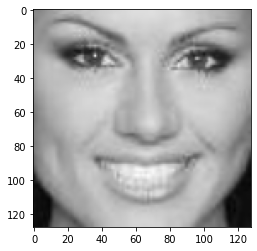

In [9]:
img,label=valid_ds[7]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

torch.Size([3, 128, 128])


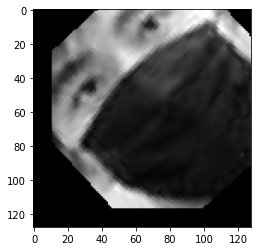

In [10]:
img,label=train_ds[45]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [11]:
classes=['mask','no mask']

In [12]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [13]:
valid_dl2 = DataLoader(valid_ds2, batch_size*2, num_workers=3, pin_memory=True)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

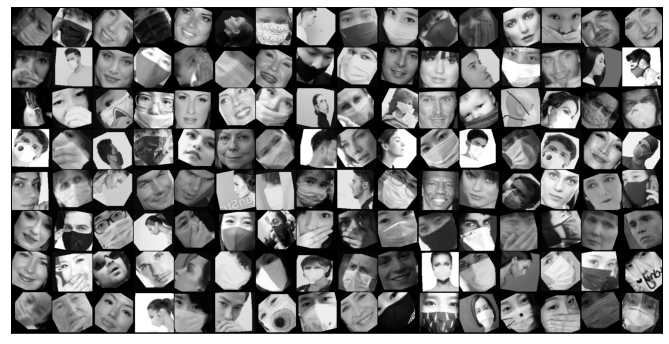

In [15]:
show_batch(train_dl)

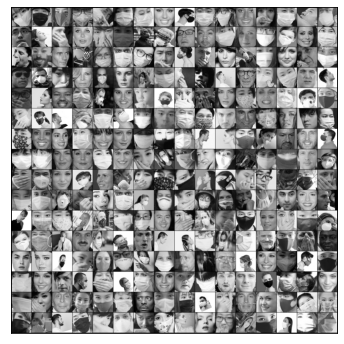

In [16]:
show_batch(valid_dl)

In [17]:
show_batch(test_dl)

NameError: name 'test_dl' is not defined

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
valid_dl2 = DeviceDataLoader(valid_dl2, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class FaceMask(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=pretrained) #pretrained inherits the weights when it was trained
        # Replace last layer
        #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        self.network.classifier[1] = nn.Linear(1280,2)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.classifier[1].parameters():
            param.require_grad = True

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(FaceMask(2), device)
model

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = FaceMask(2)
to_device(model, device);

In [ ]:
summary(model,(3,128,128))

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

98.52% accuracy in 10 epochs

In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
%%time
history += fit_one_cycle(10, max_lr, model, train_dl, valid_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Max accuracy of 99.06% obtained on 50 epochs

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    x, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
plot_lrs(history)

In [ ]:
testdata=ImageFolder('../input/testdata/Test data',valid_tfms)

In [ ]:
test_dl=DataLoader(testdata, batch_size*2,shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
test_dl=DeviceDataLoader(test_dl, device)

In [ ]:
result = evaluate(model, test_dl)
print(result)
print(len(testdata))

In [ ]:
result = evaluate(model, test_dl)
print(result)
print(len(testdata))

In [ ]:
for i in range(0,len(testdata)):
    img,label=testdata[i]
    if classes[label] != predict_image(img, model):
        print(i)

98.89% on test data, wrongly classifying 2 out of 181 images

In [ ]:
for i in range(0,len(testdata)):
    img,label=testdata[i]
    if classes[label] != predict_image(img, model):
        print(i)

#48,68

In [ ]:
result = evaluate(model, valid_dl)  #model with 50 epochs
print(result)
print(len(testdata))

97.79% on test data, wrongly classifying 4 out of 181 images

In [ ]:
for i in range(0,len(testdata)):
    img,label=testdata[i]
    if classes[label] != predict_image(img, model):
        print(i)


In [ ]:
img,label=testdata[48]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'model1.pth')

In [ ]:
torch.save(model.state_dict(), 'model3.pth')

In [ ]:
torch.save(model.state_dict(), 'model2_50ep.pth')

Model with appx 75% layers, i.e removing last 5 invertedres layers

In [ ]:
from torchvision import models

class FaceMask2(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        super().__init__()
        # Use a pretrained model
        model2 = models.mobilenet_v2(pretrained=True)
        self.network = nn.Sequential(
           *list(model2.features.children())[0:13],nn.ReLU()
        )
        self.classifier =  nn.Sequential(nn.Flatten(),nn.Dropout(0.2,inplace=False),nn.Linear(6144,2))
        # Replace last layer
        #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.classifier[1].parameters():
            param.require_grad = True

    def forward(self, xb):
        out = self.network(xb)
        out = self.classifier(out)
        return out

In [ ]:
model2 = to_device(FaceMask2(2), device)

In [ ]:
summary(model2,(3,128,128))

In [ ]:
history = [evaluate(model2, valid_dl)]
history

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Obtained an acc of 98.25% on validation dataset

In [ ]:
result = evaluate(model2, test_dl)  #75% model with 10 epochs #95.58
print(result)

In [ ]:
for i in range(0,len(testdata)): #8
    img,label=testdata[i]
    if classes[label] != predict_image(img, model2):
        print(i)

In [ ]:
img,label=testdata[16]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model2))

In [ ]:
torch.save(model2.state_dict(), 'model4_75pc.pth')

**Model with 50% layers i.e 9 inverted residual layers**

In [ ]:
from torchvision import models

class FaceMask3(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        super().__init__()
        # Use a pretrained model
        model2 = models.mobilenet_v2(pretrained=True)
        self.network = nn.Sequential(
           *list(model2.features.children())[0:10],nn.ReLU()
        )
        self.classifier =  nn.Sequential(nn.Flatten(),nn.Dropout(0.2,inplace=False),nn.Linear(4096,2))
        # Replace last layer
        #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.classifier[1].parameters():
            param.require_grad = True

    def forward(self, xb):
        out = self.network(xb)
        out = self.classifier(out)
        return out

In [ ]:
model3 = to_device(FaceMask3(2), device)

In [ ]:
summary(model3,(3,128,128))

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model3, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Accuracy of 98.12% on validation data

In [ ]:
result = evaluate(model3, test_dl)  #50% model with 10 epochs, 96.6
print(result)

In [ ]:
for i in range(0,len(testdata)): #6
    img,label=testdata[i]
    if classes[label] != predict_image(img, model3):
        print(i)

In [ ]:
img,label=testdata[2]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model3))

In [ ]:
torch.save(model3.state_dict(), 'model4_50pc.pth')

**Taking only 5 invertedresidual layers ie 25%**

In [ ]:
from torchvision import models

class FaceMask4(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        super().__init__()
        # Use a pretrained model
        model2 = models.mobilenet_v2(pretrained=True)
        self.network = nn.Sequential(
           *list(model2.features.children())[0:6],nn.ReLU()
        )
        self.classifier =  nn.Sequential(nn.Flatten(),nn.Dropout(0.2,inplace=False),nn.Linear(8192,1024),nn.ReLU(),nn.Linear(1024,2))
        # Replace last layer
        #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.classifier[1].parameters():
            param.require_grad = True

    def forward(self, xb):
        out = self.network(xb)
        out = self.classifier(out)
        return out

In [ ]:
model4 = to_device(FaceMask4(2), device)

In [ ]:
summary(model4,(3,128,128))

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model4, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
result = evaluate(model4, test_dl)  #25% model with 10 epochs #95.58
print(result)

In [ ]:
for i in range(0,len(testdata)): #8
    img,label=testdata[i]
    if classes[label] != predict_image(img, model4):
        print(i)

In [ ]:
torch.save(model4.state_dict(), 'model4_25pc.pth')

 **Therefore the best working model was initial one with all layers and ran through 10 epochs**